# PDAC LP (Inexact) Algorithm Analysis
This notebook is used to analyze the performance of the relaxed ILP (inexact) job scheduling algorithm. Specifically, it uses a greedy heuristic scheduling algorithm and a naive scheduling algorithm for comparison. The peak demand above the curve (PDAC) is measured across five different trials for each specified job batch size and then plotted on a graph. 

In [2]:
import sys
import os
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import time
import csv

# Add the parent directory of AAC/ to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

Import the relaxed ILP, greedy and naive algorithms from their respective files in the repository

In [3]:
from PDAC.pdac_scheduling_lp import solve_pdac_lp
from PDAC.pdac_scheduling_greedy import solve_pdac_greedy
from PDAC.pdac_scheduling_naive import solve_pdac_naive

# Program Parameters
In the code below, you can specify the start time, end time and maximum length of each job in each batch of jobs. \
\
&emsp;&emsp; - 0 denotes 12am and 1400 denotes 12am of the following day. \
&emsp;&emsp; - Therefore, one day contains exactly 1440 minutes of job data
\
\
Additionally, you can specify the sizes of each job batch that is analyzed in this program. \
\
&emsp;&emsp; - The start size is the smallest batch size to be analyzed \
&emsp;&emsp; - The end size is the largest batch size (exclusive) to be analyzed \
&emsp;&emsp; - The step size is how much the job batch increases per analytical trial

In [4]:
start_time = 0
end_time = 1400
max_length = 700

start_size = 500
end_size = 1200
step_size = 100

analysis_num = 2

# Resource Curve
The resource curve is represented by a list of values across the specified time period. Where at a given time t there will be exactly resources[t] amount of power available to the jobs. The data for these resources is available in the Input_Data folder. 
\
\
Additionally, each height is multiplied by a scaling factor. This is so that the resource curve better fits the job curve. Otherwise, the resource curve would be too small for any sort of significant analysis. This scaling factor remains constant for each of the trials and for every job batch size for the sake of consistency. 

In [5]:
# Instantiate the resource curve
path = r"C:\Users\moaxs\Desktop\REU 2025\PDM Project\Code\Graphs\Comparison\Input_Data\resource_data.json"
with open(path, 'r') as file:
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

day = 3
resources = total[(24 * day) + start_time : (24 * day) + end_time]

# # Implement a resource curve scaling factor to better fit the jobs
scale_factor = 4.233
resources = [r * scale_factor for r in resources]

# Algorithm Analysis
For each batch size, there will be five trials run on each algorithm. Each time, a random assortment of jobs will be provided to the algorithms. However, these jobs will be the same for each algorithm, so they will be tested on the same jobs. This is for the most accurate possible comparisons. 
\
\
Additionally, the time it takes for each algorihtm to run is measured. 

In [6]:
# This is The list of job objects that will be scheduled
# They each have a release, deadline, duration and height
path = r"C:\Users\moaxs\Desktop\REU 2025\PDM Project\Code\Graphs\Comparison\Input_Data\job_data.json"
with open(path, 'r') as file:
    data = json.load(file)

# Randomly shuffle the jobs so that there is variation between trials
jobs_array = data['jobs']

pdac_inexact = []
pdac_greedy = []
pdac_naive = []

final_data = []

for batch_size in range(start_size, end_size, step_size):
    inexact_total = 0
    inexact_copy_total = 0
    greedy_total = 0
    naive_total = 0

    print(f"\nBatch Size: {batch_size}")

    for trial in range(5):
        print(f"Trial #: {trial}")
        random.shuffle(jobs_array)

        start = time.time()
        inexact = solve_pdac_lp(jobs_array, resources, start_time, end_time, max_length, batch_size)[0]
        end = time.time()
        inexact_total += inexact
        inexact_time = end - start
        print(f"Inexact Objective: {inexact}, Elapsed Time: {(end - start):.6f}")

        start = time.time()
        greedy = solve_pdac_greedy(jobs_array, resources, start_time, end_time, max_length, batch_size)[0]
        end = time.time()
        greedy_total += greedy
        greedy_time = end - start
        print(f"Greedy Objective: {greedy}, Elapsed Time {(end - start):.6f}")

        start = time.time()
        naive = solve_pdac_naive(jobs_array, resources, start_time, end_time, max_length, batch_size)[0]
        end = time.time()
        naive_total += naive
        naive_time = end - start
        print(f"Naive Objective: {naive}, Elapsed Time: {(end - start):.6f}")

        trial_data = {
            "batch size": batch_size, 
            "trial #": trial, 
            "naive obective val": naive, 
            "naive time": naive_time, 
            "inexact objective val": inexact, 
            "inexact time": inexact_time, 
            "greedy objective val": greedy, 
            "greedy time": greedy_time
        }
        final_data.append(trial_data)

    pdac_inexact.append(inexact_total / 5)
    pdac_greedy.append(greedy_total / 5)
    pdac_naive.append(naive_total / 5)


Batch Size: 500
Trial #: 0
Inexact Objective: 1381.6960000000072, Elapsed Time: 5.375015
Greedy Objective: 4128.4120000000075, Elapsed Time 0.275839
Naive Objective: 12561.262000000035, Elapsed Time: 0.003030
Trial #: 1
Inexact Objective: 1357.5570000000007, Elapsed Time: 6.632644
Greedy Objective: 4132.107000000004, Elapsed Time 0.303218
Naive Objective: 14408.206999999999, Elapsed Time: 0.003000
Trial #: 2
Inexact Objective: 3592.5870000000104, Elapsed Time: 5.428873
Greedy Objective: 5664.542000000005, Elapsed Time 0.276088
Naive Objective: 15083.201999999994, Elapsed Time: 0.005623
Trial #: 3
Inexact Objective: 5303.4319999999825, Elapsed Time: 5.089114
Greedy Objective: 8868.091999999993, Elapsed Time 0.240408
Naive Objective: 12692.966999999993, Elapsed Time: 0.005467
Trial #: 4
Inexact Objective: 1987.8320000000058, Elapsed Time: 5.035470
Greedy Objective: 3207.2670000000107, Elapsed Time 0.312704
Naive Objective: 13573.017000000018, Elapsed Time: 0.004011

Batch Size: 600
Tria

In [7]:
inexact_list = [x / 1000 for x in pdac_inexact]

greedy_list = [x / 1000 for x in pdac_greedy]

naive_list = [x / 1000 for x in pdac_naive]

# Plot the Results
Use the results from the previous cell to plot the PDAC over different batch sizes for each of the three algorithms 

- BW Graph

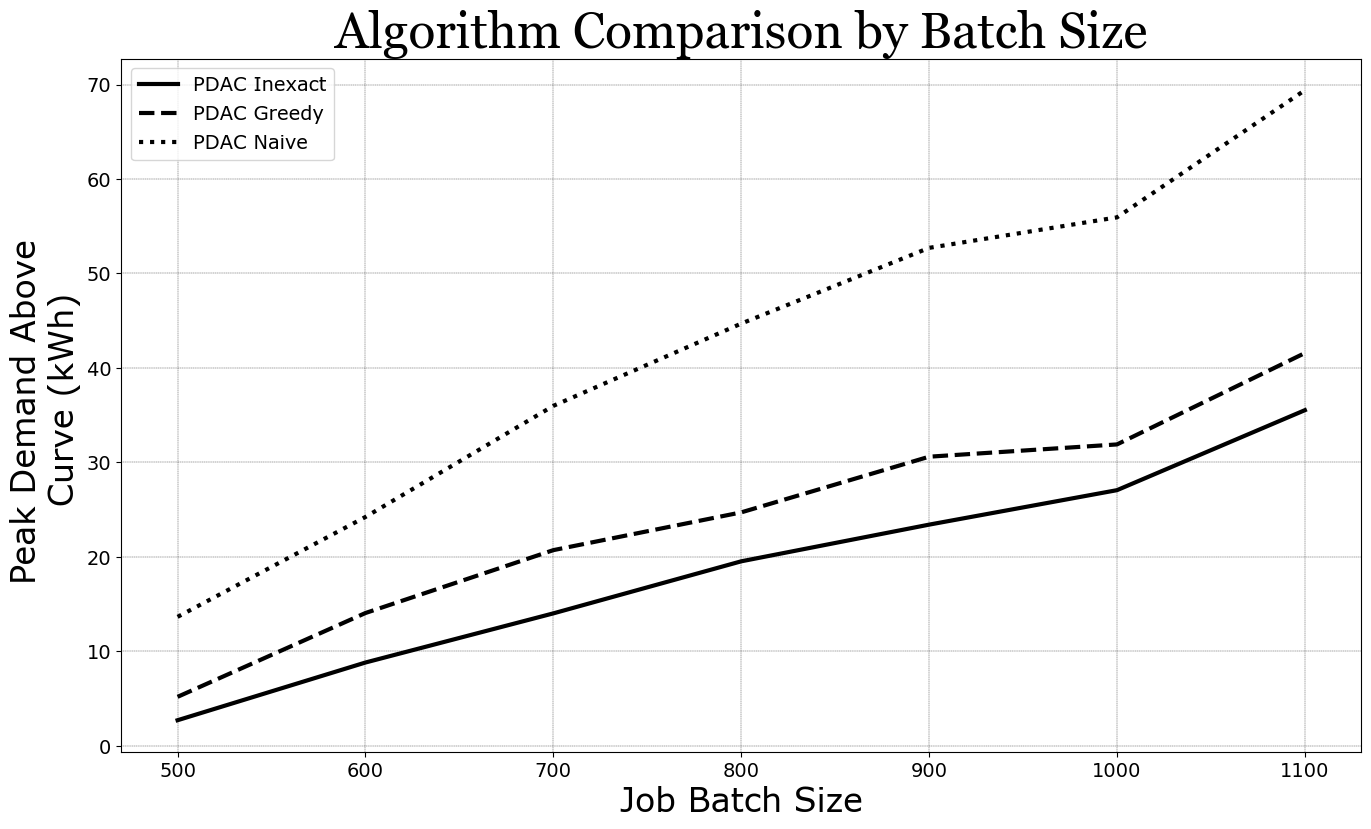

In [16]:
fig, ax = plt.subplots(figsize=(16,9))

# Plot data
job_graph_xvalues = [i for i in range(start_size, end_size, step_size)]
ax.plot(job_graph_xvalues, inexact_list, label="PDAC Inexact", linestyle='-', color = 'black', linewidth=3)
ax.plot(job_graph_xvalues, greedy_list, label="PDAC Greedy", linestyle='--', color = 'black', linewidth=3)
ax.plot(job_graph_xvalues, naive_list, label="PDAC Naive", linestyle=':', color = 'black', linewidth=3)

ax.grid(True, linestyle='--', linewidth=0.25, color='black')
plt.tick_params(axis='both', labelsize=14)
ax.set_xticks(np.arange(start_size, end_size, step_size))
ax.set_yticks(np.arange(0, max(naive_list)+10, 10))

ax.set_title("Algorithm Comparison by Batch Size", fontsize=36, fontname="Georgia", color='black')
ax.set_xlabel("Job Batch Size", fontsize=24, fontname='Verdana', color='black')
ax.set_ylabel("Peak Demand Above \n Curve (kWh)", fontsize=24, fontname='Verdana', color='black')
ax.legend(loc='upper left', prop={'family': 'Verdana', 'size': 14})

plt.show()

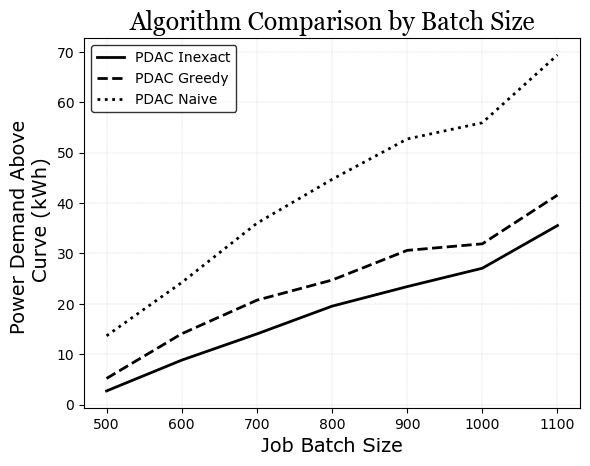

In [8]:
job_graph_xvalues = [i for i in range(start_size, end_size, step_size)]

plt.plot(job_graph_xvalues, inexact_list, label="PDAC Inexact", linestyle='-', color = 'black', linewidth=2)
plt.plot(job_graph_xvalues, greedy_list, label="PDAC Greedy", linestyle='--', color = 'black', linewidth=2)
plt.plot(job_graph_xvalues, naive_list, label="PDAC Naive", linestyle=':', color = 'black', linewidth=2)

plt.grid(True, linestyle='--', linewidth=0.25, alpha=.25, color='black')
plt.xticks(np.arange(start_size, end_size, step_size))
plt.yticks(np.arange(0, max(naive_list)+10, 10))

plt.style.use('default')
plt.title("Algorithm Comparison by Batch Size", fontsize=18, fontname="Georgia")
plt.xlabel("Job Batch Size", fontsize=14, fontname='Verdana')
plt.ylabel("Power Demand Above \n Curve (kWh)", fontsize=14, fontname='Verdana')
plt.legend(loc='upper left', fontsize='medium', edgecolor='black', prop={'family': 'Verdana', 'size': 10})
plt.show()

- Color Graph

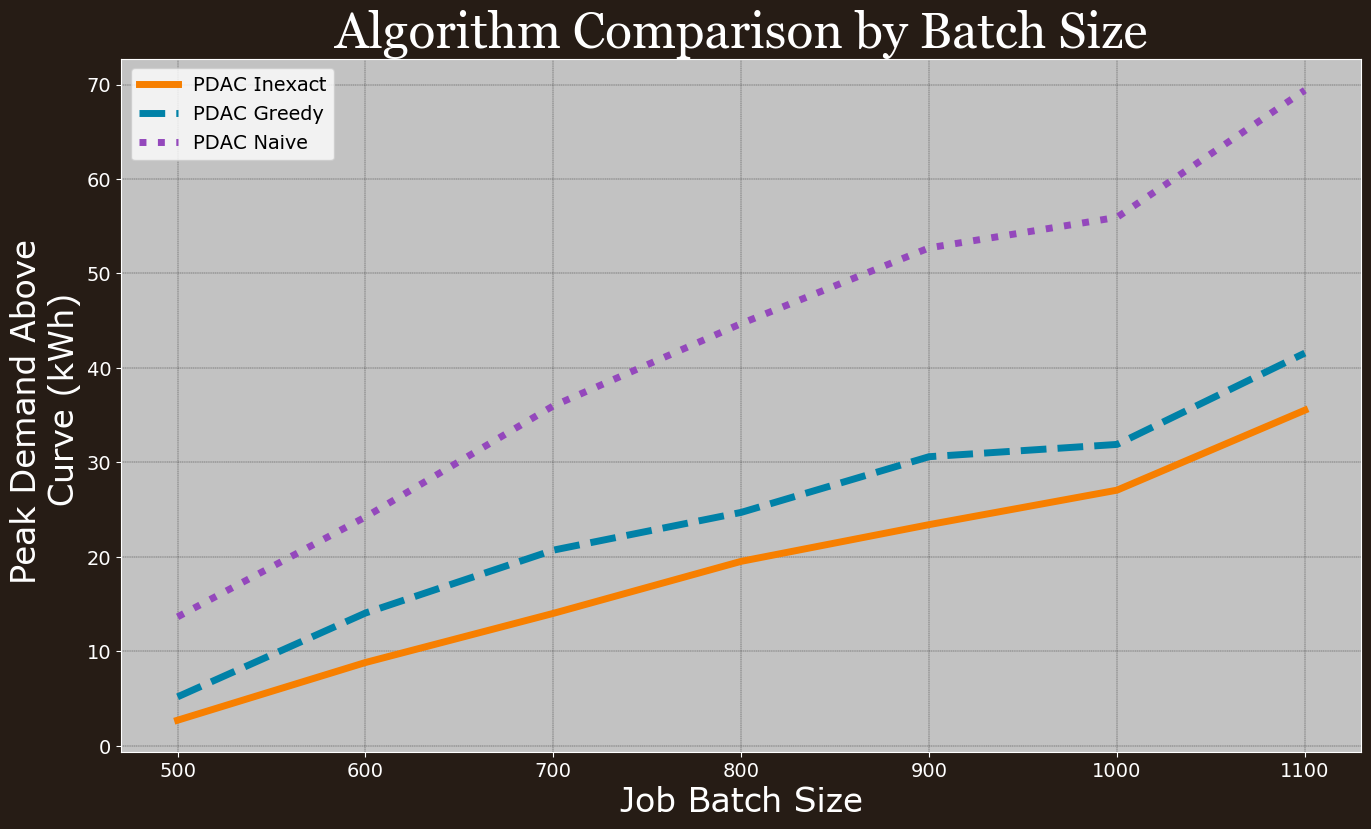

In [13]:
fig, ax = plt.subplots(figsize=(16,9))

# Set figure (outside) background
fig.patch.set_facecolor("#261c15")

# Set axes (plot area) background
ax.set_facecolor("#c2c2c2")

# Plot data
job_graph_xvalues = [i for i in range(start_size, end_size, step_size)]
ax.plot(job_graph_xvalues, inexact_list, label="PDAC Inexact", linestyle='-', color = '#f77f00', linewidth=5)
ax.plot(job_graph_xvalues, greedy_list, label="PDAC Greedy", linestyle='--', color = '#0081a7', linewidth=5)
ax.plot(job_graph_xvalues, naive_list, label="PDAC Naive", linestyle=':', color = '#9448bc', linewidth=5)

ax.grid(True, linestyle='--', linewidth=0.25, color='black')
plt.tick_params(axis='both', labelsize=14)
ax.set_xticks(np.arange(start_size, end_size, step_size))
ax.set_yticks(np.arange(0, max(naive_list)+10, 10))

ax.set_title("Algorithm Comparison by Batch Size", fontsize=36, fontname="Georgia", color='white')
ax.set_xlabel("Job Batch Size", fontsize=24, fontname='Verdana', color='white')
ax.set_ylabel("Peak Demand Above \n Curve (kWh)", fontsize=24, fontname='Verdana', color='white')
ax.legend(loc='upper left', prop={'family': 'Verdana', 'size': 14})

ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

# Export Data
Export the analyzed data so that it can be archived for future use.

In [10]:
folder_path= r"C:\Users\moaxs\Desktop\REU 2025\PDM Project\Code\Graphs\Output_Data\PDAC_Results"
os.makedirs(folder_path, exist_ok=True)

In [11]:
import csv
# Write to a data csv file
with open(f"{folder_path}/inexact_pdac_analysis_{analysis_num}.csv", "a", newline="") as csvfile:
    fieldnames = ['batch size', 'trial #', 'naive obective val', 'naive time', 'inexact objective val', 'inexact time', 'greedy objective val', 'greedy time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Only write the header on the very first trial run
    writer.writeheader()
    writer.writerows(final_data)

    csvfile.close()